# Example of inverse scattering solution using PDE-constrained optimization

In [1]:
import numpy as np
#import scipy as sp

import matplotlib.pyplot as plt
from functools import partial

from jax import jit

import jax
import jax.numpy as jnp

# for optimization
import jax.scipy.optimize
#import jaxopt


# this is the package to solve
import solver.jax_fd as jax_fd
import solver.near_field as near_field

from solver.perturbations import shepp_logan_transform, three_bumps

In [2]:
# size of the domain in x and y
ax = 1.0
ay = 1.0

# number of discretization points per dimension
nxi = 80
nyi = nxi

# PML
npml = 20
sigmaMax = 80

nx = nxi + 2*npml
ny = nx

#omega = 2*jnp.pi*(nyi//10)
omega = 2*jnp.pi*10


order = 2

# grid spacing
hx = 1/(nxi-1)

sampling_radius = 1.0
n_angles = nxi


In [3]:
# initialize the parameters
params_nf = near_field.init_params_near_field_plane(ax, ay, nxi, nyi,npml,
                                         sampling_radius,
                                         n_angles, omega, sigmaMax)

In [4]:
# we sample the perturbation
eta = three_bumps(params_nf.fd_params.Xi, params_nf.fd_params.Yi) 
#m = 1 + eta
eta_vect = np.reshape(eta, (-1,))
#m_vect = np.reshape(m, (-1,))

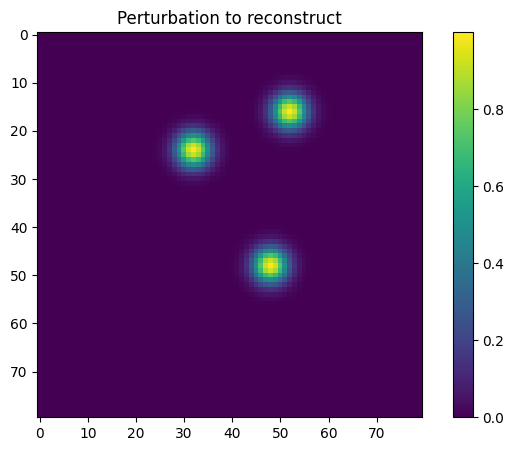

In [5]:
plt.figure(figsize=(8,5))
plt.imshow(jnp.real(eta_vect).reshape((nxi,nyi)))
#plt.xticks([])
#plt.yticks([])
plt.title('Perturbation to reconstruct', color='black')
plt.colorbar()
plt.show()

In [6]:
eta_ext = near_field.ExtendModel(eta, nxi, nyi, npml)

In [7]:
tol = 1e-02
#H = jax_fd.HelmholtzMatrix(m_ext, params_nf.fd_params.nx, params_nf.fd_params.ny,
#                           params_nf.fd_params.npml, params_nf.fd_params.h,
#                           params_nf.fd_params.SigmaMax, order, omega, 'compact_explicit')
H = jax_fd.HelmholtzMatrix_off_diag(params_nf.fd_params.nx, params_nf.fd_params.ny,
                                    params_nf.fd_params.npml, params_nf.fd_params.h,
                                    params_nf.fd_params.SigmaMax, order, omega)

In [8]:
near_field_ = near_field.NearField(H, omega, params_nf, tol)
#near_field_jit = jit(near_field_())

In [9]:
#field = near_field_jit(eta_ext)
field = near_field_()(eta_ext)

In [10]:
Lambda = near_field.smoothing_solution(field, params_nf, n_angles, sampling_radius)

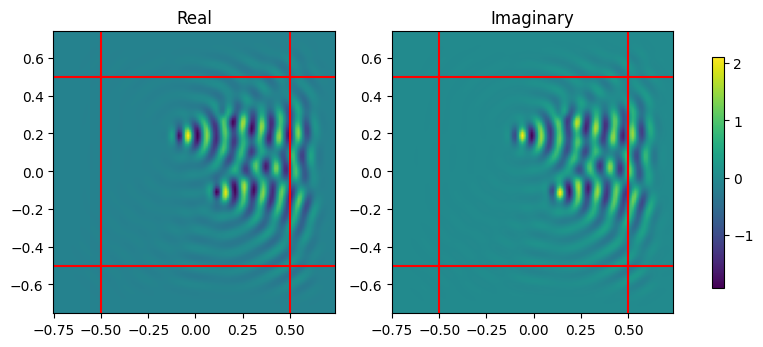

In [11]:
near_field.DisplayField(field[:,0],params_nf.fd_params.x,params_nf.fd_params.y, npml)

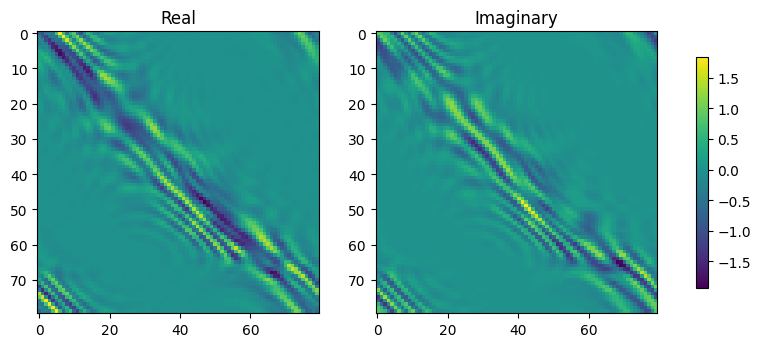

In [12]:
near_field.DisplayField(Lambda, params_nf.fd_params.xi,params_nf.fd_params.yi)

## Optimization process

In [13]:
projection_mat = near_field.get_projection_mat(params_nf, n_angles, sampling_radius)

In [14]:
eta_0 = jnp.real(0*eta_vect)

In [15]:
misfit_ = near_field.MisFit(H, omega, params_nf, tol, Lambda, projection_mat)
misfit_jit = jit(misfit_())

In [ ]:
opt_result = jax.scipy.optimize.minimize(misfit_jit, x0=eta_0, method='BFGS')

opt_eta_vect = opt_result.x

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,5))


im1 = ax1.imshow(jnp.real(opt_eta_vect).reshape((nxi,nyi)))
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('reconstructed media', color='black')
fig.colorbar(im1, ax=ax1)

im2 =ax2.imshow(jnp.real(eta_vect).reshape((nxi,nyi)))
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('reference media', color='black')
fig.colorbar(im2, ax=ax2)

im3 = ax3.imshow(jnp.abs(eta_vect - opt_eta_vect).reshape((nxi,nyi)))
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_title('error', color='black')
fig.colorbar(im3, ax=ax3)

plt.show()